#### Import necessary libraries

In [1]:
import chess
import chess.svg
import subprocess
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output, SVG
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import psutil
import torch
import chess.engine
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind, gaussian_kde
from scipy.stats import levene
import pickle
from matplotlib.colors import LinearSegmentedColormap

## LC0 and Stockfish

### Initialization of Chess Board and Widgets

In [2]:
board = chess.Board()
board_output = widgets.Output()
info_output = widgets.Output()

#### Display the last move made

In [3]:
opponent_move_display = widgets.Text(
    description='Last Move:',
    disabled=True,
    layout=widgets.Layout(width='300px')
)

#### Input field for player's move

In [4]:
move_input = widgets.Text(
    description='Move:',
    placeholder='e.g., e2e4',
    layout=widgets.Layout(width='200px')
)

#### Change your paths

In [5]:
LC0_PATH = Path("D:/GitHub/lc0/lc0.exe")
STOCKFISH_PATH = Path("D:/stockfish/stockfish-windows-x86-64-avx2.exe")
engine_selector = widgets.Dropdown(
    options=[('Leela Chess Zero', 'lc0'),
             ('Stockfish',        'stockfish')],
    value='stockfish',
    description='Engine:',
    layout=widgets.Layout(width='250px')
)

### Function Definitions

#### Function to Display the Chessboard

In [6]:
def show_board(board):
    svg_content = chess.svg.board(board=board, size=400)
    display(SVG(svg_content))

#### Function to Get the Best Move

In [7]:
def get_best_move(fen=None,
                  time_limit=2000,
                  engine_name='lc0',
                  options=None):

    engine_path = LC0_PATH if engine_name=='lc0' else STOCKFISH_PATH
    proc = subprocess.Popen(
        str(engine_path),
        stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE,
        universal_newlines=True, bufsize=1,
        cwd=str(engine_path.parent)
    )

    def send(cmd):
        proc.stdin.write(cmd + "\n")
        proc.stdin.flush()

    send("uci")
    engine_id = None
    for line in proc.stdout:
        line = line.strip()
        if line.startswith("id name"):
            engine_id = line.split("id name",1)[1].strip()
        if line=="uciok":
            break

    if engine_name=='stockfish' and options:
        for name,val in options.items():
            send(f"setoption name {name} value {val}")

    send("ucinewgame")
    send(f"position fen {fen}" if fen else "position startpos")
    send(f"go movetime {time_limit}")

    best_move, score = None, None
    for line in proc.stdout:
        line = line.strip()
        if line.startswith("info") and "score" in line:
            parts = line.split()
            if "cp" in parts:
                try:
                    idx = parts.index("score")
                    score = int(parts[idx+2])
                except:
                    pass
            elif "mate" in parts:
                try:
                    idx = parts.index("score")
                    m = int(parts[idx+2])
                    score = 100000 if m>0 else -100000
                except:
                    pass
        elif line.startswith("bestmove"):
            best_move = line.split()[1]
            break

    send("quit")
    proc.terminate()
    proc.wait()

    return best_move, score, engine_id

#### Function to Make a Move on the Board

In [8]:
def make_move(move_str):
    try:
        move = chess.Move.from_uci(move_str)
        if move in board.legal_moves:
            board.push(move)
            return True
        else:
            print("Illegal move.")
            return False
    except ValueError:
        print("Invalid move format.")
        return False

#### Function to Update the Board and Show Information

In [9]:
def show_position():
    with board_output:
        clear_output(wait=True)
        show_board(board)

    with info_output:
        clear_output(wait=True)
        if not board.is_game_over():
            best_move, best_score, engine_id = get_best_move(board.fen(),engine_name=engine_selector.value)
            if best_move:
                best_move_uci = best_move
                all_legal_moves = list(board.legal_moves)
                random_moves = random.sample(all_legal_moves, 2)

                moves_with_best = [best_move_uci] + [move.uci() for move in random_moves]
                chosen_move = random.choice(moves_with_best)

                print(f"[{engine_id}] recommends: {best_move}"f"  (eval {best_score/100:+.2f})")
                print(f"Position evaluation: {best_score / 100 if best_score else 'undefined'}")
                print(f"{'White' if board.turn else 'Black'} is making a move")

            if board.move_stack:
                last_move = board.move_stack[-1]
                piece = board.piece_at(chess.parse_square(last_move.uci()[2:]))

                if piece:
                    piece_name = {
                        chess.PAWN: "pawn",
                        chess.KNIGHT: "knight",
                        chess.BISHOP: "bishop",
                        chess.KING: "king",
                        chess.QUEEN: "queen",
                        chess.ROOK: "rook"
                    }[piece.piece_type]
                    opponent_move_display.value = f"{piece_name} {last_move.uci()}"
        else:
            result = "Checkmate!" if board.is_checkmate() else "Stalemate!" if board.is_stalemate() else "Draw!"
            print(f"Game Over. {result}")

#### Function to Update the Board and Information

In [10]:
def update_board_and_info():
    show_position()

#### Function for the Computer to Make a Move (for Black's Turn)

In [11]:
def play_computer_move():
    if not board.is_game_over() and board.turn == chess.BLACK:
        best_move, best_score = get_best_move(board.fen())
        if best_move:
            best_move_uci = best_move
            all_legal_moves = list(board.legal_moves)
            random_moves = random.sample(all_legal_moves, 2)

            moves_with_best = [best_move_uci] + [move.uci() for move in random_moves]
            move = random.choice(moves_with_best)
            make_move(move)
            print(f"Computer made the move: {move}")
            update_board_and_info()

#### Handler for Button Click

In [12]:
def handle_button_click(action):
    if action == 'move':
        move_str = move_input.value.strip().lower()
        if move_str:
            if make_move(move_str):
                move_input.value = ''
            update_board_and_info()
            play_computer_move()

    elif action == 'undo':
        if len(board.move_stack) >= 2:
            board.pop()
            board.pop()
            opponent_move_display.value = ''
            update_board_and_info()

        else:
            with info_output:
                clear_output(wait=True)
                print("Cannot undo move.")

    elif action == 'new_game':
        board.reset()
        opponent_move_display.value = ''
        update_board_and_info()

#### Button Handlers for Move, Undo, and New Game

In [13]:
def on_move_button_click(b):
    handle_button_click("move")

def on_undo_button_click(b):
    handle_button_click("undo")

def on_new_game_button_click(b):
    handle_button_click("new_game")

#### Create Input and Control Widgets

In [14]:
move_input = widgets.Text(
    description='Move:',
    placeholder='e.g., e2e4',
    layout=widgets.Layout(width='200px')
)

move_button = widgets.Button(description="Make Move", button_style="success")
undo_button = widgets.Button(description="Undo Move", button_style="warning")
new_game_button = widgets.Button(description="New Game", button_style="info")


#### Button Creation and Custom Layout Styling

In [15]:
move_button = widgets.Button(
    description="Make Move",
    layout=widgets.Layout(width="200px", height="50px"),
    style={'button_color': '#9fc3d1', 'font_weight': 'bold'}
)

undo_button = widgets.Button(
    description="Undo Move",
    layout=widgets.Layout(width="200px", height="50px"),
    style={'button_color': '#4a656d', 'font_weight': 'bold'}
)

new_game_button = widgets.Button(
    description="New Game",
    layout=widgets.Layout(width="200px", height="50px"),
    style={'button_color': '#86abb6', 'font_weight': 'bold'}
)

#### Bind Buttons to Functions

In [16]:
move_button.on_click(on_move_button_click)
undo_button.on_click(on_undo_button_click)
new_game_button.on_click(on_new_game_button_click)

#### Layout for Controls

In [17]:
controls = widgets.VBox([
    engine_selector,
    widgets.HBox([move_input, move_button]),
    widgets.HBox([undo_button, new_game_button]),
    opponent_move_display
])

#### Display the Interface

In [18]:
display(controls)
display(board_output)
display(info_output)

update_board_and_info()

Output()

Output()

### Visualization

#### Connect CPU and GPU

In [19]:
def is_gpu_available():
    return torch.cuda.is_available()

In [20]:
def measure_load(cpu_only=False):
    cpu_usage = psutil.cpu_percent(interval=0.1)
    gpu_usage = 0
    if not cpu_only and is_gpu_available():
        gpu_usage = torch.cuda.memory_allocated()
    return cpu_usage, gpu_usage

#### Automatic game from which I got data

##### Examples of evaluations_white, evaluations_black, cpu_usage_list, gpu_usage_list

In [21]:
def play_full_game(engine_name,
                   time_limit=2000,
                   options=None):

    board.reset()
    evals_w, evals_b = [], []
    cpu_list, gpu_list, move_times = [], [], []
    move_num = 1

    while not board.is_game_over():
        start = time.time()

        opts = options if engine_name == 'stockfish' else None
        mv, sc, eid = get_best_move(
            fen=board.fen(),
            time_limit=time_limit,
            engine_name=engine_name,
            options=opts
        )
        if not mv:
            break

        make_move(mv)
        target = evals_w if board.turn==chess.WHITE else evals_b
        target.append((sc, move_num, eid))

        cpu, gpu = measure_load(cpu_only=False)
        cpu_list.append(cpu); gpu_list.append(gpu)
        move_times.append((time.time()-start)*1000)

        move_num += 1
        update_board_and_info()

    return evals_w, evals_b, cpu_list, gpu_list, move_times

In [22]:
def run_multiple_games(engine_name, num_games=30, time_limit=2000, options=None):
    all_eval_w, all_eval_b = [], []
    all_cpu, all_gpu, all_times = [], [], []

    for i in range(num_games):
        print(f"\n--- Starting game {i+1}/{num_games} with {engine_name} ---")
        eval_w, eval_b, cpu_list, gpu_list, move_times = play_full_game(
            engine_name, time_limit=time_limit, options=options
        )

        all_eval_w.extend(eval_w)
        all_eval_b.extend(eval_b)
        all_cpu.extend(cpu_list)
        all_gpu.extend(gpu_list)
        all_times.extend(move_times)

    return all_eval_w, all_eval_b, all_cpu, all_gpu, all_times

In [23]:
#results_lc0_30 = run_multiple_games('lc0', num_games=30, time_limit=2000)
#results_sf_def_30 = run_multiple_games('stockfish', num_games=30, time_limit=2000)

#(ev_w_lc0, ev_b_lc0, cpu_lc0, gpu_lc0, t_lc0) = results_lc0_30
#(ev_w_def, ev_b_def, cpu_sf_def, gpu_sf_def, t_sf_def) = results_sf_def_30

#### Sample Data

In [24]:
with open('results_lc0_30.pkl', 'rb') as f:
    ev_w_lc0, ev_b_lc0, cpu_lc0, gpu_lc0, t_lc0 = pickle.load(f)

with open('results_sf_def_30.pkl', 'rb') as f:
    ev_w_def, ev_b_def, cpu_sf_def, gpu_sf_def, t_sf_def = pickle.load(f)

with open('results_sf_tuned_30.pkl', 'rb') as f:
    ev_w_tun, ev_b_tun, cpu_sf_tun, gpu_sf_tun, t_sf_tun = pickle.load(f)

with open('results_h2h_30.pkl', 'rb') as f:
    (h2h_evals_lc0, h2h_evals_sf,
     h2h_cpu_lc0,  h2h_cpu_sf,
     h2h_gpu_lc0,  h2h_gpu_sf,
     h2h_times) = pickle.load(f)

#### Function for CPU and GPU load graphing

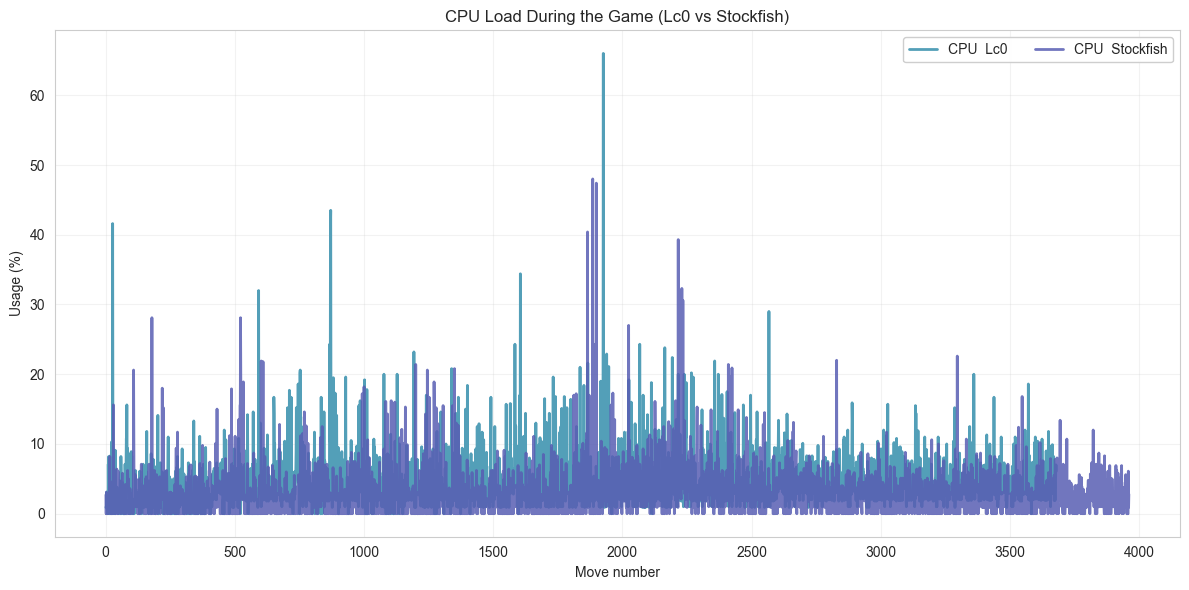

In [25]:
def plot_load_lines(cpu_lc0, gpu_lc0, cpu_sf, gpu_sf, smooth=1):

    def ma(arr, k):
        if k <= 1: return np.array(arr)
        return np.convolve(arr, np.ones(k)/k, mode='valid')

    x_lc0 = np.arange(1, len(cpu_lc0)+1)
    x_sf  = np.arange(1, len(cpu_sf)+1)

    fig, ax = plt.subplots(figsize=(12,6))

    ax.plot(x_lc0[smooth-1:], ma(cpu_lc0, smooth),
            label='CPU  Lc0',  color='#539fb8', linewidth=2)

    ax.plot(x_sf[smooth-1:],  ma(cpu_sf, smooth),
            label='CPU  Stockfish',  color='#585eb3', linewidth=2, alpha=0.85)

    ax.set_xlabel('Move number')
    ax.set_ylabel('Usage (%)')
    ax.set_title('CPU Load During the Game (Lc0 vs Stockfish)')
    ax.grid(alpha=0.25)
    ax.legend(ncol=2, framealpha=0.95)
    plt.tight_layout()
    fig.savefig("cpu_load_comparison.png", dpi=300)
    plt.show()

plot_load_lines(cpu_lc0, gpu_lc0, cpu_sf_def, gpu_sf_def, smooth=1)

#### Function for time tracking for one stroke

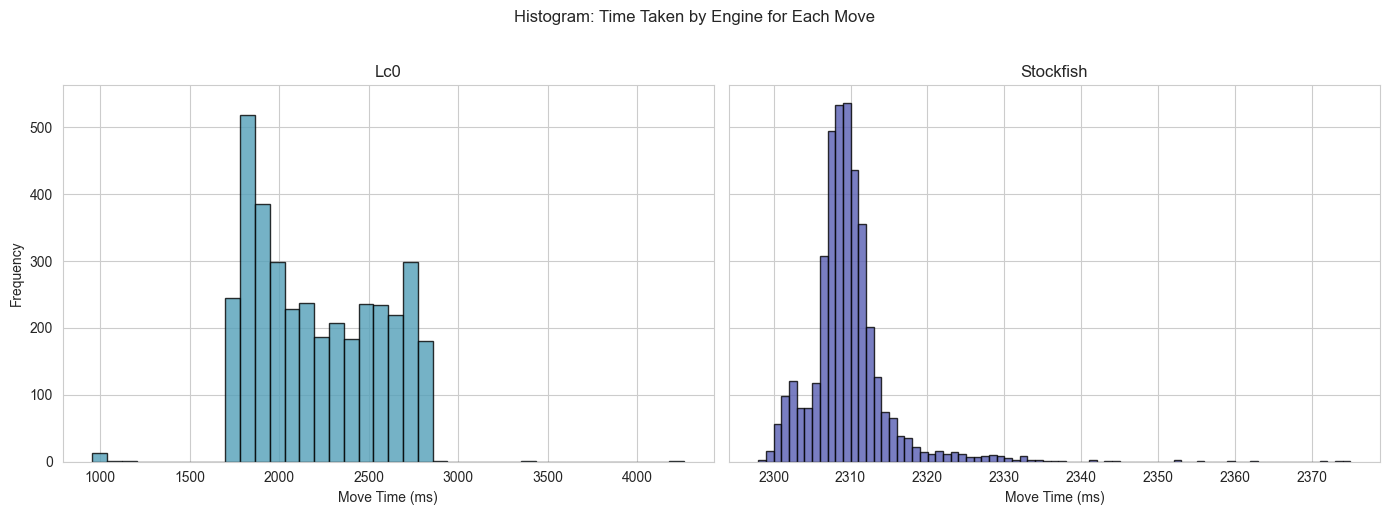

In [26]:
def fd_bin_width(data):
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    return max(1, 2 * iqr / len(data) ** (1/3))

def plot_time_hist_side_by_side(times_lc0, times_sf,
                                color_lc0='#539fb8', color_sf='#585eb3'):
    bw1 = fd_bin_width(times_lc0)
    bw2 = fd_bin_width(times_sf)

    bins_lc0 = np.arange(min(times_lc0), max(times_lc0) + bw1, bw1)
    bins_sf  = np.arange(min(times_sf),  max(times_sf)  + bw2, bw2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    axes[0].hist(times_lc0, bins=bins_lc0, color=color_lc0,
                 edgecolor='black', alpha=0.8)
    axes[0].set_title('Lc0')
    axes[0].set_xlabel('Move Time (ms)')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(times_sf,  bins=bins_sf,  color=color_sf,
                 edgecolor='black', alpha=0.8)
    axes[1].set_title('Stockfish')
    axes[1].set_xlabel('Move Time (ms)')

    fig.suptitle('Histogram: Time Taken by Engine for Each Move', y=1.02)
    plt.tight_layout()
    plt.savefig("move_time_hist.png", dpi=300)
    plt.show()

plot_time_hist_side_by_side(t_lc0, t_sf_def)


####  Function for position evaluation per move

In [27]:
def pos_evaluation(white, black):
    w = [t[0] for t in white]
    b = [t[0] for t in black]
    if len(w) > len(b):
        b += [0] * (len(w) - len(b))
    elif len(b) > len(w):
        w += [0] * (len(b) - len(w))
    return w, b

#### Match between Lc0 and Stockfish

In [28]:
def play_head2head(time_limit=2000):
    board.reset()
    evals_lc0, evals_sf = [], []
    cpu_lc0,  cpu_sf    = [], []
    gpu_lc0,  gpu_sf    = [], []
    move_times          = []

    engine_cycle = [('lc0', {}), ('stockfish', {})]
    ply = 0
    while not board.is_game_over():
        eng_name, opts = engine_cycle[ply % 2]
        start = time.time()
        move, score, _ = get_best_move(board.fen(), time_limit=time_limit,
                                       engine_name=eng_name, options=opts)
        if not move: break
        make_move(move)
        target = evals_lc0 if eng_name == 'lc0' else evals_sf
        target.append((score, ply+1, eng_name))
        c, g = measure_load()
        (cpu_lc0 if eng_name=='lc0' else cpu_sf).append(c)
        (gpu_lc0 if eng_name=='lc0' else gpu_sf).append(g)
        move_times.append((time.time()-start)*1000)
        ply += 1
    return (evals_lc0, evals_sf, cpu_lc0, cpu_sf, gpu_lc0, gpu_sf, move_times)

def run_head2head_games(num_games=30, time_limit=2000):
    all_eval_lc0, all_eval_sf = [], []
    all_cpu_lc0, all_cpu_sf   = [], []
    all_gpu_lc0, all_gpu_sf   = [], []
    all_times                 = []

    for i in range(num_games):
        print(f"\n--- H2H game {i+1}/{num_games} ---")
        ev_lc0, ev_sf, cpu_lc0, cpu_sf, gpu_lc0, gpu_sf, t = play_head2head(time_limit)

        all_eval_lc0.extend(ev_lc0);  all_eval_sf.extend(ev_sf)
        all_cpu_lc0.extend(cpu_lc0);  all_cpu_sf.extend(cpu_sf)
        all_gpu_lc0.extend(gpu_lc0);  all_gpu_sf.extend(gpu_sf)
        all_times.extend(t)

    return (all_eval_lc0, all_eval_sf,
            all_cpu_lc0,  all_cpu_sf,
            all_gpu_lc0,  all_gpu_sf,
            all_times)

#(h2h_evals_lc0, h2h_evals_sf,
# h2h_cpu_lc0,  h2h_cpu_sf,
# h2h_gpu_lc0,  h2h_gpu_sf,
# h2h_times) = run_head2head_games(num_games=30, time_limit=2000)

#### Move-comparison between Lc0 and Stockfish

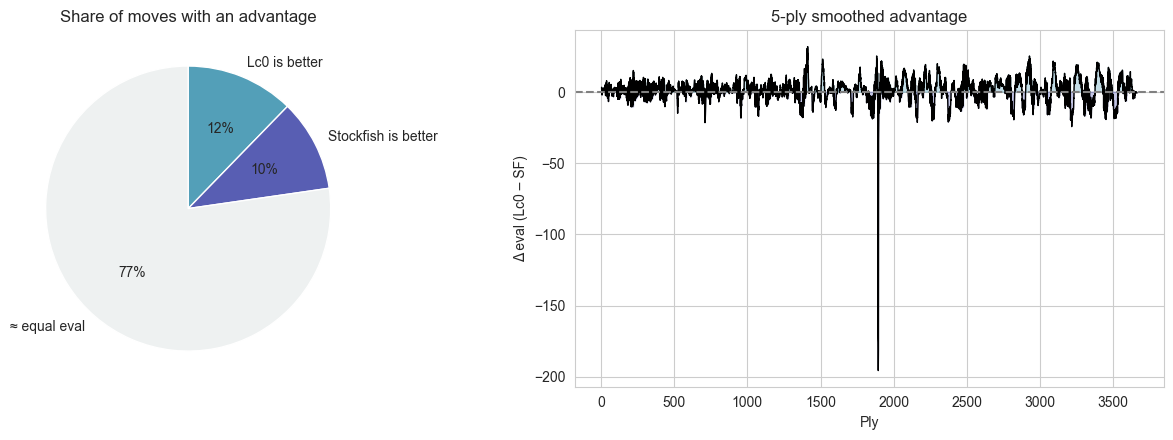

In [29]:
def flat(ev_w, ev_b):
    seq = []
    for w, b in zip(ev_w, ev_b + [None]):
        seq.append(w[0])
        if b is not None: seq.append(b[0])
    return np.array(seq, float)

seq_lc0 = flat(ev_w_lc0, ev_b_lc0)
seq_sf  = flat(ev_w_def,  ev_b_def)

n      = min(len(seq_lc0), len(seq_sf))
diff   = seq_lc0[:n] - seq_sf[:n]
k      = 5
smooth = np.convolve(diff, np.ones(k)/k, 'valid')
x      = np.arange(len(smooth)) + k//2 + 1

eq_band = 25
sizes = [(diff >  eq_band).sum(),
         (diff < -eq_band).sum(),
         (np.abs(diff) <= eq_band).sum()]
labels = ['Lc0 is better', 'Stockfish is better', '≈ equal eval']
colors = ['#539fb8', '#585eb3', '#eef1f1']

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

axes[0].pie(sizes, labels=labels, autopct='%1.0f%%',
            colors=colors, startangle=90, counterclock=False)
axes[0].set_title('Share of moves with an advantage')

axes[1].fill_between(x, 0, smooth, where=smooth>=0,
                     color='#539fb8', alpha=.35)
axes[1].fill_between(x, 0, smooth, where=smooth<0,
                     color='#585eb3', alpha=.35)
axes[1].plot(x, smooth, c='black', lw=1)
axes[1].axhline(0, ls='--', c='grey')
axes[1].set_xlabel('Ply')
axes[1].set_ylabel('Δ eval (Lc0 – SF)')
axes[1].set_title(f'{k}-ply smoothed advantage')

plt.tight_layout()
fig.savefig("advantage_pie_and_area.png", dpi=300)
plt.show()


#### tuned Stockfish

In [30]:
tuned_opts = {
    'Hash': 256,
    'Threads': 4,
    'Ponder': False,
    'MultiPV': 1,
    'Contempt': 24,
    'Skill Level': 20,
    'Slow Mover': 80
}
#results_sf_tuned = play_full_game('stockfish', time_limit=2000, options=tuned_opts)

#(ev_w_tun, ev_b_tun, cpu_sf_tun, gpu_sf_tun, t_sf_tun) = results_sf_tuned

### Hypothesis

#### Hypothesis 1: Move time distributions are the same for Lc0 and default Stockfish
##### H₀: The distribution of move times for LCZero is the same as that for Stockfish.
##### H₁: The distributions of move times are different between LCZero and Stockfish.

Kolmogorov–Smirnov Test:
KS Statistic: 0.5841839844490021
p-value: 0.0
-> reject H0 -> The distributions are significantly different.


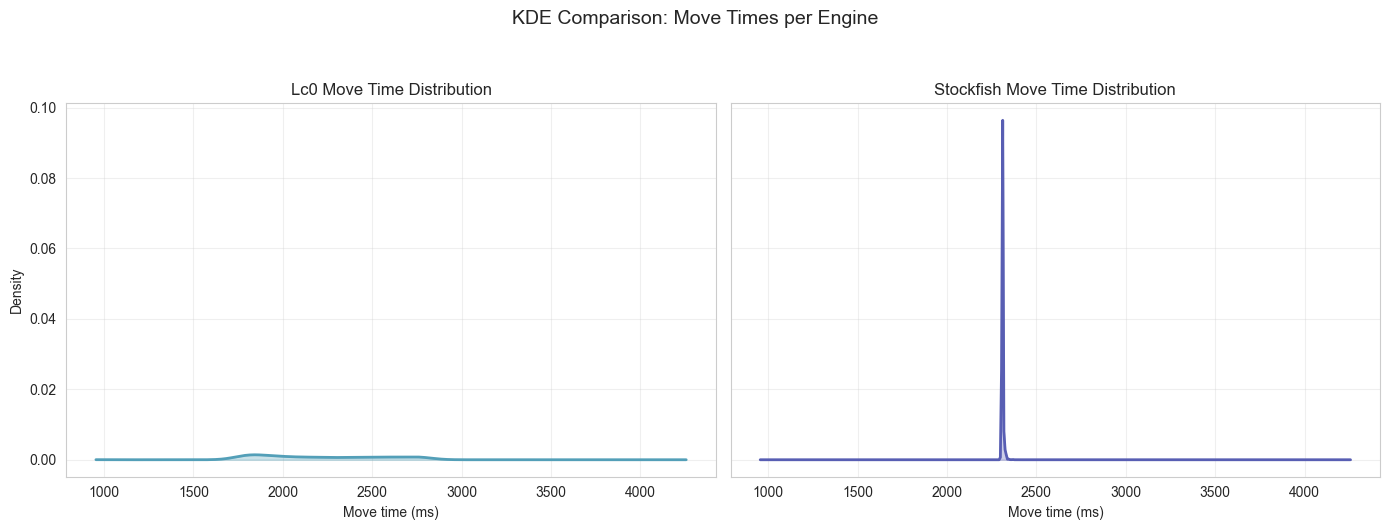

In [31]:
t_lc0_clean = np.array([x for x in t_lc0 if isinstance(x, (int, float)) and np.isfinite(x)])
t_sf_def_clean = np.array([x for x in t_sf_def if isinstance(x, (int, float)) and np.isfinite(x)])

ks_stat, ks_pvalue = ks_2samp(t_lc0_clean, t_sf_def_clean)

print("Kolmogorov–Smirnov Test:")
print(f"KS Statistic: {ks_stat}")
print(f"p-value: {ks_pvalue}")

if ks_pvalue < 0.05:
    print("-> reject H0 -> The distributions are significantly different.")
else:
    print("-> fail to reject H0 -> No significant difference in distributions.")
t_lc0_clean = np.array([x for x in t_lc0 if isinstance(x, (int, float)) and np.isfinite(x)])
t_sf_def_clean = np.array([x for x in t_sf_def if isinstance(x, (int, float)) and np.isfinite(x)])

kde_lc0 = gaussian_kde(t_lc0_clean)
kde_sf = gaussian_kde(t_sf_def_clean)

x_min = min(t_lc0_clean.min(), t_sf_def_clean.min())
x_max = max(t_lc0_clean.max(), t_sf_def_clean.max())
x_vals = np.linspace(x_min, x_max, 500)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].plot(x_vals, kde_lc0(x_vals), color='#539fb8', linewidth=2)
axes[0].fill_between(x_vals, kde_lc0(x_vals), alpha=0.3, color='#539fb8')
axes[0].set_title("Lc0 Move Time Distribution")
axes[0].set_xlabel("Move time (ms)")
axes[0].set_ylabel("Density")
axes[0].grid(alpha=0.3)

axes[1].plot(x_vals, kde_sf(x_vals), color='#585eb3', linewidth=2)
axes[1].fill_between(x_vals, kde_sf(x_vals), alpha=0.3, color='#585eb3')
axes[1].set_title("Stockfish Move Time Distribution")
axes[1].set_xlabel("Move time (ms)")
axes[1].grid(alpha=0.3)

plt.suptitle("KDE Comparison: Move Times per Engine", fontsize=14, y=1.05)
plt.tight_layout()
plt.savefig("hypothesis1_move_time_kde.png", dpi=300)
plt.show()

#### Hypothesis 2: CPU usage variability is the same for LCZero and Stockfish.
##### H₀: The variance of CPU usage per move is equal for LCZero and Stockfish.
##### H₁: The variance of CPU usage per move is significantly different between LCZero and Stockfish.

Levene’s Test: CPU Variability
Statistic: 6.076217508580943
p-value: 0.013724058650667148
-> reject H0 -> Variance is significantly different. LCZero is more variable.


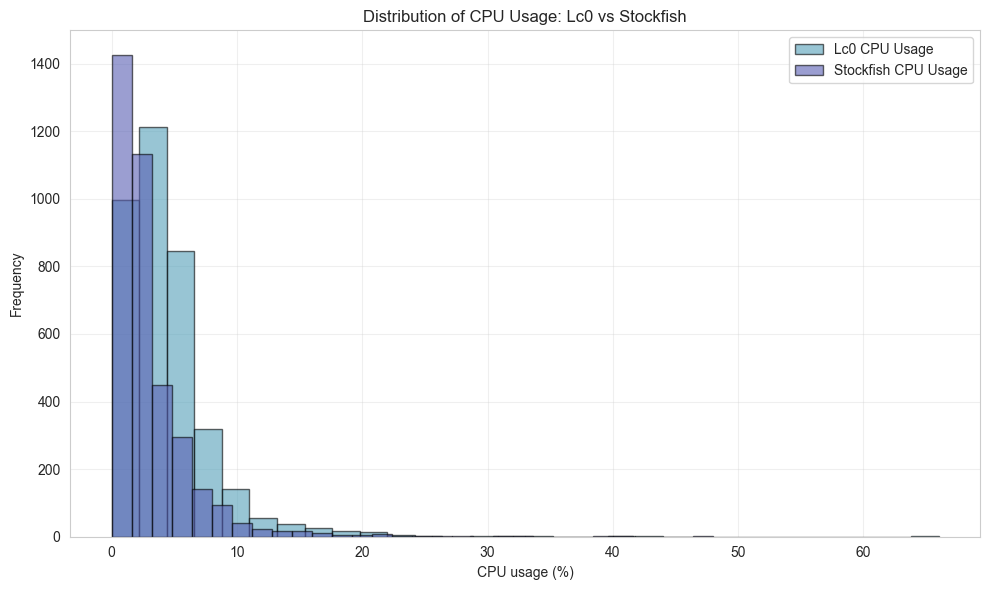

In [32]:
cpu_lc0_clean = np.array([x for x in cpu_lc0 if isinstance(x, (int, float)) and np.isfinite(x)])
cpu_sf_clean = np.array([x for x in cpu_sf_def if isinstance(x, (int, float)) and np.isfinite(x)])

min_len = min(len(cpu_lc0_clean), len(cpu_sf_clean))
cpu_lc0_clean = cpu_lc0_clean[:min_len]
cpu_sf_clean = cpu_sf_clean[:min_len]

stat, pval = levene(cpu_lc0_clean, cpu_sf_clean)

print("Levene’s Test: CPU Variability")
print(f"Statistic: {stat}")
print(f"p-value: {pval}")

if pval < 0.05:
    print("-> reject H0 -> Variance is significantly different. LCZero is more variable.")
else:
    print("-> fail to reject H0 -> No significant difference in variance.")

plt.figure(figsize=(10, 6))
plt.hist(cpu_lc0_clean, bins=30, alpha=0.6, label='Lc0 CPU Usage', color='#539fb8', edgecolor='black')
plt.hist(cpu_sf_clean, bins=30, alpha=0.6, label='Stockfish CPU Usage', color='#585eb3', edgecolor='black')
plt.title("Distribution of CPU Usage: Lc0 vs Stockfish")
plt.xlabel("CPU usage (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("hypothesis2_cpu_hist.png", dpi=300)
plt.show()

#### Hypothesis 3: The mean evaluation scores produced by the default and tuned versions of Stockfish are equal.
##### H₀: The average evaluation score from Default Stockfish is equal to that from Tuned Stockfish.
##### H₁: The average evaluation scores are different.

T-test: Mean Evaluation (Default vs Tuned Stockfish)
Statistic: -0.202
p-value: 8.400e-01
-> fail to reject H0 -> No significant difference in means.


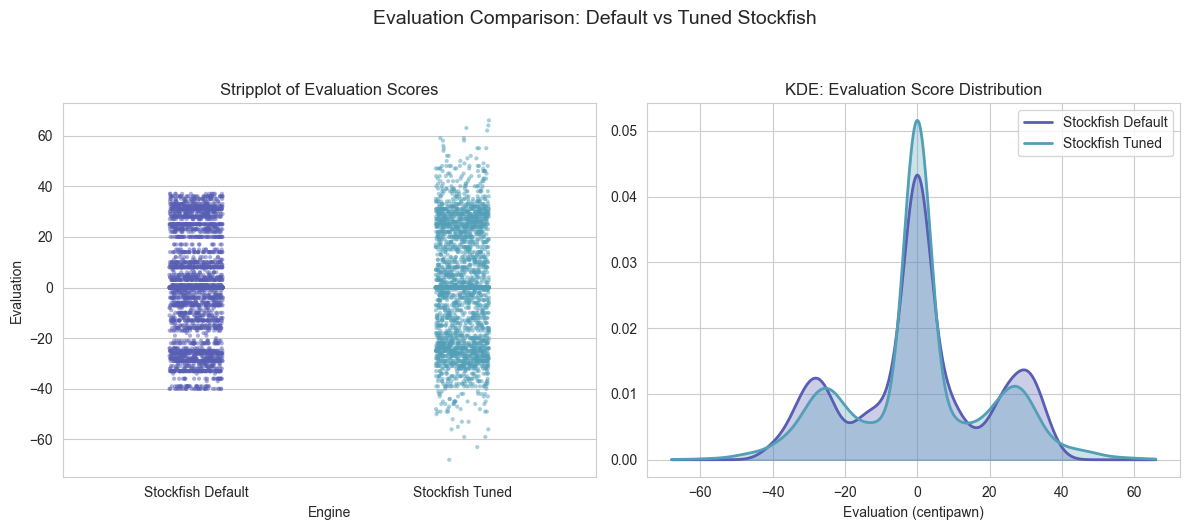

In [33]:
evals_default_clean = np.array([
    s for s, _, _ in ev_w_def + ev_b_def
    if isinstance(s, (int, float)) and np.isfinite(s)
])

evals_tuned_clean = np.array([
    s for s, _, _ in ev_w_tun + ev_b_tun
    if isinstance(s, (int, float)) and np.isfinite(s)
])

stat, pval = ttest_ind(evals_default_clean, evals_tuned_clean, equal_var=False)

print("T-test: Mean Evaluation (Default vs Tuned Stockfish)")
print(f"Statistic: {stat:.3f}")
print(f"p-value: {pval:.3e}")
if pval < 0.05:
    print("-> reject H0 -> Means are significantly different.")
else:
    print("-> fail to reject H0 -> No significant difference in means.")

df_eval = pd.DataFrame({
    "Evaluation": np.concatenate([evals_default_clean, evals_tuned_clean]),
    "Engine": ["Stockfish Default"] * len(evals_default_clean) +
              ["Stockfish Tuned"] * len(evals_tuned_clean)
})

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.stripplot(
    x="Engine",
    y="Evaluation",
    data=df_eval,
    hue="Engine",
    dodge=False,
    palette={"Stockfish Default": "#585eb3", "Stockfish Tuned": "#539fb8"},
    size=3,
    alpha=0.5,
    jitter=True,
    legend=False
)
plt.title("Stripplot of Evaluation Scores")

plt.subplot(1, 2, 2)
kde_def = gaussian_kde(evals_default_clean)
kde_tun = gaussian_kde(evals_tuned_clean)

x_min = min(evals_default_clean.min(), evals_tuned_clean.min())
x_max = max(evals_default_clean.max(), evals_tuned_clean.max())
x_vals = np.linspace(x_min, x_max, 500)

plt.plot(x_vals, kde_def(x_vals), label="Stockfish Default", color="#585eb3", linewidth=2)
plt.fill_between(x_vals, kde_def(x_vals), alpha=0.3, color="#585eb3")

plt.plot(x_vals, kde_tun(x_vals), label="Stockfish Tuned", color="#539fb8", linewidth=2)
plt.fill_between(x_vals, kde_tun(x_vals), alpha=0.3, color="#539fb8")

plt.title("KDE: Evaluation Score Distribution")
plt.xlabel("Evaluation (centipawn)")
plt.legend()

plt.suptitle("Evaluation Comparison: Default vs Tuned Stockfish", fontsize=14, y=1.05)
plt.tight_layout()
plt.savefig("hypothesis3_eval_comparison.png", dpi=300)
plt.show()

#### Hypothesis 4: Move time distributions are the same
##### H₀: The distributions of move computation times for Default and Tuned Stockfish are the same.
##### H₁: The distributions of move times differ significantly between the two versions.

Kolmogorov–Smirnov test:
 KS statistic = 0.9992518703241895
 p-value = 0.0
-> reject H0 -> Distributions differ significantly.


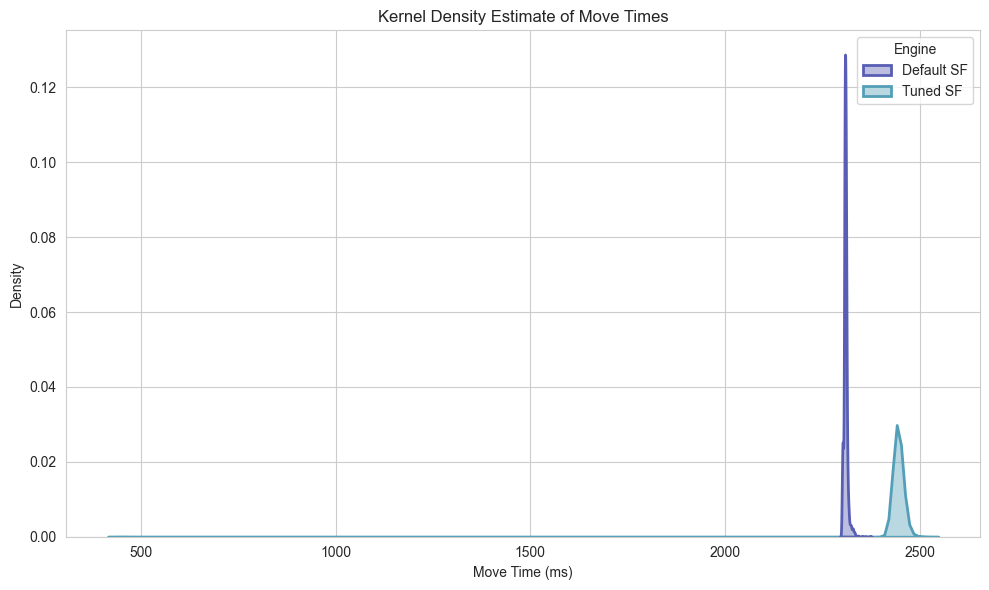

In [34]:
times_def = np.array(t_sf_def)
times_tun = np.array(t_sf_tun)

ks_stat, ks_p = ks_2samp(times_def, times_tun)
print("Kolmogorov–Smirnov test:")
print(f" KS statistic = {ks_stat}")
print(f" p-value = {ks_p}")
if ks_p < 0.05:
    print("-> reject H0 -> Distributions differ significantly.")
else:
    print("-> fail to reject H0 -> No significant difference in distributions.")

df = pd.DataFrame({
    "Move Time (ms)": np.concatenate([times_def, times_tun]),
    "Engine": ["Default SF"] * len(times_def) + ["Tuned SF"] * len(times_tun)
})

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df,
    x="Move Time (ms)",
    hue="Engine",
    fill=True,
    common_norm=False,
    alpha=0.4,
    palette={"Default SF": "#585eb3", "Tuned SF": "#539fb8"},
    linewidth=2
)
plt.title("Kernel Density Estimate of Move Times")
plt.xlabel("Move Time (ms)")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("hypothesis4_move_time_kde.png", dpi=300)
plt.show()

### Comparison Table

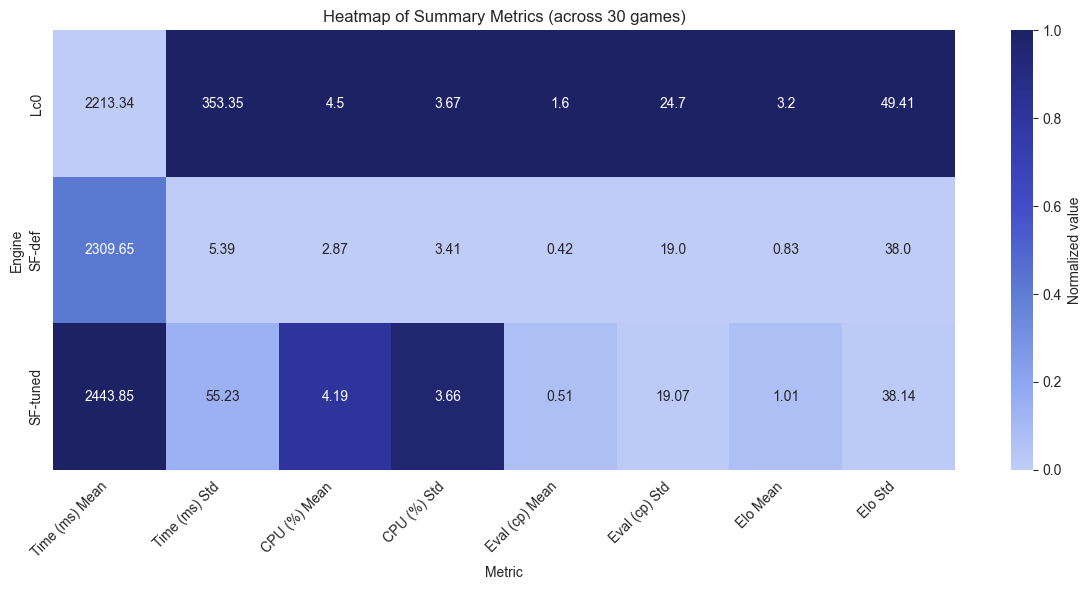

In [35]:
custom_cmap = LinearSegmentedColormap.from_list(
    "lc0_sf_tuned",
    ['#beccf7', "#8da6f1", "#5e7dd3", "#424cc8", '#2e369f', '#1d2265'],
    N=256
)

def flatten(ev_w, ev_b):
    seq = []
    for w, b in zip(ev_w, ev_b + [None]):
        seq.append(w[0])
        if b is not None:
            seq.append(b[0])
    return np.array(seq, dtype=float)

seq_lc0 = flatten(ev_w_lc0, ev_b_lc0)
seq_def = flatten(ev_w_def,  ev_b_def)
seq_tun = flatten(ev_w_tun,  ev_b_tun)

t_lc0 = np.array([x for x in t_lc0 if np.isfinite(x)], dtype=float)
t_def  = np.array([x for x in t_sf_def if np.isfinite(x)], dtype=float)
t_tun  = np.array([x for x in t_sf_tun if np.isfinite(x)], dtype=float)

cpu_lc0 = np.array([x for x in cpu_lc0 if np.isfinite(x)], dtype=float)
cpu_def = np.array([x for x in cpu_sf_def if np.isfinite(x)], dtype=float)
cpu_tun = np.array([x for x in cpu_sf_tun if np.isfinite(x)], dtype=float)

def summarize(arr, name):
    return {
        f"{name} Mean": np.mean(arr),
        f"{name} Std": np.std(arr)
    }

metrics = {
    'Lc0': {},
    'SF-def': {},
    'SF-tuned': {}
}

metrics['Lc0'].update(summarize(t_lc0,   'Time (ms)'))
metrics['Lc0'].update(summarize(cpu_lc0, 'CPU (%)'))
metrics['Lc0'].update(summarize(seq_lc0, 'Eval (cp)'))

metrics['SF-def'].update(summarize(t_def,   'Time (ms)'))
metrics['SF-def'].update(summarize(cpu_def, 'CPU (%)'))
metrics['SF-def'].update(summarize(seq_def, 'Eval (cp)'))

metrics['SF-tuned'].update(summarize(t_tun,   'Time (ms)'))
metrics['SF-tuned'].update(summarize(cpu_tun, 'CPU (%)'))
metrics['SF-tuned'].update(summarize(seq_tun, 'Eval (cp)'))

df_summary = pd.DataFrame(metrics).T

df_summary['Elo Mean'] = df_summary['Eval (cp) Mean'] * 2
df_summary['Elo Std']  = df_summary['Eval (cp) Std']  * 2

df_norm = (df_summary - df_summary.min()) / (df_summary.max() - df_summary.min())

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    df_norm,
    annot=df_summary.round(2),
    fmt='',
    cmap=custom_cmap,
    vmin=0, vmax=1,
    cbar_kws={'label': 'Normalized value'}
)
plt.title('Heatmap of Summary Metrics (across 30 games)')
plt.ylabel('Engine')
plt.xlabel('Metric')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
fig.savefig("summary_metrics_heatmap.png", dpi=300)
plt.show()